In [2]:
# Basic Template
%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext nb_black
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path

<IPython.core.display.Javascript object>

In [5]:
from pyzpl import (
    NSC,
    NSCObject,
    NSCSource,
    NSCDetector,
    read_ddr,
    incoherent_irradiance,
    coherent_irradiance,
)

<IPython.core.display.Javascript object>

### Example macro
NCS is a class that holds the macro

In [6]:
macro = NSC()

<IPython.core.display.Javascript object>

### Setup a 2d sim

In [7]:
n_detectors = 1
system_radius = 0.1
system_material = "WATER"

environment_parameters = [(1, 2 * system_radius), (2, 1)]
environment_properites = [(141, 1), (4, system_material)]
# 141 Sets the do not draw object checkbox. Use 1 for checked, 0 for unchecked.

macro.add(
    NSCObject(
        "Sphere",
        (0, 0, 0, 0, 0, 0),
        parameters=environment_parameters,
        properties=environment_properites,
    )
)

<IPython.core.display.Javascript object>

### Source

In [8]:
def rotate(x, y, angle_deg):
    theta = np.radians(angle_deg)
    x_new = (x * np.cos(theta)) - (y * np.sin(theta))
    y_new = (x * np.sin(theta)) + (y * np.cos(theta))
    return x_new, y_new


def source_size(height, width, angle):
    points = [(height, width), (height, -width), (-height, width), (-height, -width)]
    rot_points = [rotate(*p, angle) for p in points]
    h = max([abs(p[0]) for p in rot_points])
    w = max([abs(p[1]) for p in rot_points])
    return h, w


def sim_source_positions(radius, angle, z_offset=0):
    retval = []
    for ang in [-angle, 0, angle]:
        z, x = rotate(-1, 0, ang)
        y = 0
        pos = (radius * x, radius * y, radius * z + z_offset, 0, ang, 0)
        retval.append(pos)
    return retval


polarization_angle = 0
grid_angle = 0
analysis_rays = 1e6
zeroth = True
illumination_phase = 0
illumination_angle = 65
illumination_z_offset = 0

# SOURCE
Jx, Jy = rotate(1, 0, polarization_angle)
source_half_width, source_half_height = source_size(
    detector_half_width, detector_half_height, grid_angle
)
sourceparameters = [
    (1, 10),  # Layout rays
    (2, analysis_rays),  # Analysis rays
    (6, 1.1 * source_half_width),  # width
    (7, 1.1 * source_half_height),  # height
]
sourcepos = sim_source_positions if zeroth else sim_source_positions_2d
diff_order = [-1, 0, 1] if zeroth else [-1, 1]

source_properties = [
    [
        (3, 1),  # inside of
        (101, 1),  # raandoma polarixation
        (107, k * illumination_phase),  # phase
        # (103, Jx),  # Jones X
        # (104, Jy),  # Jones Y
    ]
    for k in diff_order
]

for pos, prop in zip(
    sourcepos(system_radius, illumination_angle, illumination_z_offset),
    source_properties,
):
    macro.add(
        NSCSource(
            "Source Rectangle",
            pos,
            parameters=sourceparameters,
            properties=prop,
        )
    )

NameError: name 'detector_half_width' is not defined

<IPython.core.display.Javascript object>

### Capillary

In [9]:
def capillary_objects(
    radius, thickness, height, grid_angle, material="BK7", buffer="WATER"
):
    ro, ri = radius, radius - thickness
    assert ri > 0, "Thickness cannot be larger than radius"

    dx = -np.sin(np.radians(grid_angle)) * height / 2
    dy = -(1 - np.cos(np.radians(grid_angle))) * height / 2
    outer_cylinder_params = [(1, ro), (2, height), (3, ro)]
    inner_cylinder_params = [(1, ri), (2, height), (3, ri)]
    outer_cylinder_properites = [(4, material)]
    inner_cylinder_properites = [(4, buffer)]

    cyl_glass = NSCObject(
        "Cylinder Volume",
        (dx, height / 2 + dy, 0, 90, grid_angle, 0),
        parameters=outer_cylinder_params,
        properties=outer_cylinder_properites,
    )

    cyl_buffer = NSCObject(
        "Cylinder Volume",
        (dx, height / 2 + dy, 0, 90, grid_angle, 0),
        parameters=inner_cylinder_params,
        properties=inner_cylinder_properites,
    )

    return [cyl_glass, cyl_buffer]


capillary = True
capillary_material = "BK7"
capillary_buffer = "WATER"
capillary_radius = 0.007
capillary_height = 0.05
capillary_thickness = 0.001

detector_half_width = 0.007
detector_half_height = 0.007 / 8

# CYLINDER
if capillary:
    for c in capillary_objects(
        capillary_radius,
        capillary_thickness,
        capillary_height,
        grid_angle,
        material=capillary_material,
        buffer=capillary_buffer,
    ):
        macro.add(c)

<IPython.core.display.Javascript object>

### Dectector

In [10]:
resolution_width = 512
resolution_height = 512 / 8

# DETECTOR
detectorparameters = [
    (1, detector_half_width),
    (2, detector_half_height),
    (3, resolution_width),
    (4, resolution_height),
]
for i in range(n_detectors):
    macro.add(
        NSCDetector(
            "Detector Rectangle",
            (0, 0, 0, 0, 0, grid_angle),
            parameters=detectorparameters,
        )
    )

<IPython.core.display.Javascript object>

In [11]:
macro.clear()
macro.initialize_objects()
macro.update()

<IPython.core.display.Javascript object>

### Define measurements

In [12]:
folder = Path(os.getcwd()) / "temp"
ddr_file = folder / "sim2d_ref.DDR"
macro.clear_detectors()
macro.nstr()
macro.savedetector(macro.object_index(NSCDetector)[0], folder / "sim2d_ref.DDR")

<IPython.core.display.Javascript object>

In [14]:
print(macro)

! NCXT NSC Generator Macro
! Axel EKman

! this part is used to clear the NSC editor
totalobjNum = NOBJ(1)
for i, totalobjNum, 1, -1
    DELETEOBJECT 1, i
next

!Insert objects
INSERTOBJECT 1,1
INSERTOBJECT 1,1
INSERTOBJECT 1,1
INSERTOBJECT 1,1

!Set Object parameters
SETNSCPROPERTY 1, 1, 0, 0, "NSC_SPHE"
SETNSCPOSITION 1, 1, 1, 0
SETNSCPOSITION 1, 1, 2, 0
SETNSCPOSITION 1, 1, 3, 0
SETNSCPOSITION 1, 1, 4, 0
SETNSCPOSITION 1, 1, 5, 0
SETNSCPOSITION 1, 1, 6, 0
SETNSCPARAMETER 1, 1, 1, 0.2
SETNSCPARAMETER 1, 1, 2, 1
SETNSCPROPERTY 1, 1, 141, 0, 1
SETNSCPROPERTY 1, 1, 4, 0, WATER

SETNSCPROPERTY 1, 2, 0, 0, "NSC_CBLK"
SETNSCPOSITION 1, 2, 1, -0
SETNSCPOSITION 1, 2, 2, 0.025
SETNSCPOSITION 1, 2, 3, 0
SETNSCPOSITION 1, 2, 4, 90
SETNSCPOSITION 1, 2, 5, 0
SETNSCPOSITION 1, 2, 6, 0
SETNSCPARAMETER 1, 2, 1, 0.007
SETNSCPARAMETER 1, 2, 2, 0.05
SETNSCPARAMETER 1, 2, 3, 0.007
SETNSCPROPERTY 1, 2, 4, 0, BK7

SETNSCPROPERTY 1, 3, 0, 0, "NSC_CBLK"
SETNSCPOSITION 1, 3, 1, -0
SETNSCPOSITION 1, 3, 2, 0.0

<IPython.core.display.Javascript object>

### Run macro via OS command line
- if argument, saves macro to folder, else initializes a temp file

In [69]:
_ = macro.run()

Saving at  C:\Users\axela\Documents\GitHub\pyzemax\__temp.zpl
Process finished


<IPython.core.display.Javascript object>

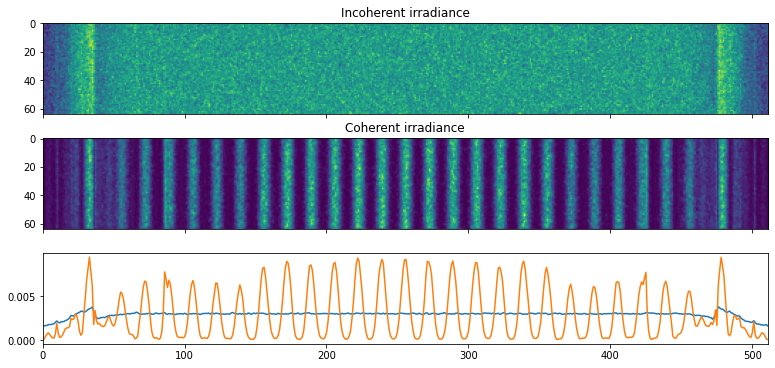

<IPython.core.display.Javascript object>

In [70]:
def plot_profile(data):
    f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(13, 6), sharex=True)

    ax1.imshow(incoherent_irradiance(data))
    ax2.imshow(coherent_irradiance(data))

    ax1.set_title("Incoherent irradiance")
    ax2.set_title("Coherent irradiance")

    ax3.plot(np.sum(incoherent_irradiance(data), 0))
    ax3.plot(np.sum(coherent_irradiance(data), 0))
    #     fix fgraph aspect to match image
    asp = np.diff(ax3.get_xlim())[0] / np.diff(ax3.get_ylim())[0]
    asp /= np.abs(np.diff(ax1.get_xlim())[0] / np.diff(ax1.get_ylim())[0])
    ax3.set_aspect(asp)

    ax3.set_xlim(0, 511)


image_data = read_ddr(ddr_file)
plot_profile(image_data)